#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/wbc.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df.iloc[:-1,:]
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,21.100000,21.530001,21.049999,21.41,21.41,5459593.0,1.35,2.5,125.0
5747,28/07/2022,21.610001,21.650000,21.410000,21.43,21.43,5165682.0,1.35,2.5,125.0
5748,29/07/2022,21.510000,21.600000,21.469999,21.51,21.51,7000330.0,1.35,2.5,125.0
5749,1/08/2022,21.500000,21.660000,21.230000,21.66,21.66,6824049.0,1.35,2.5,125.0
5750,2/08/2022,21.610001,22.020000,21.559999,22.00,22.00,6402716.0,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.wbc.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.wbc.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wbc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.wbc.delete_one(
    {'Date': last_date}
)

DELETE: 29/08/2022 21.270000457763672


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wbc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

NEW LAST VALUE IN MONGODB: 26/08/2022 21.68000030517578


In [6]:
from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

Previous last date in MongoDb: 26-08-2022. Today's date: 30-08-2022


In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'WBC.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-26,21.799999,21.549999,21.549999,21.680000,3903593,21.680000
2022-08-29,21.340000,21.160000,21.250000,21.270000,4858793,21.270000
2022-08-30,21.450001,21.280001,21.280001,21.280001,4913810,21.280001


In [8]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,21.340000,21.160000,21.250000,21.270000,4858793,21.270000
2022-08-30,21.450001,21.280001,21.280001,21.280001,4913810,21.280001


In [9]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_41224/775055212.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_41224/775055212.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_41224/775055212.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,21.340000,21.160000,21.250000,21.270000,4858793,21.270000,1.85,2.5,125
1,30/08/2022,21.450001,21.280001,21.280001,21.280001,4913810,21.280001,1.85,2.5,125


In [10]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/08/2022',
  'High': 21.34000015258789,
  'Low': 21.15999984741211,
  'Open': 21.25,
  'Close': 21.270000457763672,
  'Volume': 4858793,
  'Adj Close': 21.270000457763672,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '30/08/2022',
  'High': 21.450000762939453,
  'Low': 21.280000686645508,
  'Open': 21.280000686645508,
  'Close': 21.280000686645508,
  'Volume': 4913810,
  'Adj Close': 21.280000686645508,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125}]

In [11]:
#INSERT NEW DATA INTO MONGODB
db.wbc.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.wbc.find()))

last_val = df_mongo.iloc[-20:].values
print(last_val)

[[ObjectId('62eccb790b9367ab254e8a2d') '03/08/2022' 21.760000228881836
  21.84000015258789 21.579999923706055 21.75 21.75 5826387.0 1.85 2.5
  125.0]
 [ObjectId('62eccb790b9367ab254e8a2e') '04/08/2022' 21.979999542236328
  22.079999923706055 21.844999313354492 21.850000381469727
  21.850000381469727 3950722.0 1.85 2.5 125.0]
 [ObjectId('62f0d1b36258df9785119f03') '05/08/2022' 21.950000762939453
  22.0 21.860000610351562 21.959999084472656 21.959999084472656 3523637.0
  1.85 2.5 125.0]
 [ObjectId('62f22301af5bd29652105878') '08/08/2022' 21.940000534057617
  22.100000381469727 21.84000015258789 22.06999969482422
  22.06999969482422 3955084.0 1.85 2.5 125.0]
 [ObjectId('62f370c0fe264916b3667e94') '09/08/2022' 22.0
  22.020000457763672 21.729999542236328 21.899999618530273
  21.899999618530273 6709172.0 1.85 2.5 125.0]
 [ObjectId('62f6ffd89f1566d03b3f9628') '10/08/2022' 22.0
  22.290000915527344 21.915000915527344 22.200000762939453
  22.200000762939453 6487316.0 1.85 2.5 125.0]
 [ObjectId

In [12]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

30/08/2022 21.280000686645508


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [13]:
df_mongo = pd.DataFrame(list(db.wbc.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()

# # # del data[0]
len_df_mongo=len(df_mongo)

data = df_mongo.filter(["Close"])
dataset=data.values
dataset

array([[10.435952  ],
       [10.240284  ],
       [10.051568  ],
       ...,
       [21.68000031],
       [21.27000046],
       [21.28000069]])

In [14]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape

In [15]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4591, 1)

In [16]:
last60=train_data[60:]
print(last60)

[[0.01077541]
 [0.01007048]
 [0.01342732]
 ...
 [0.69007399]
 [0.68230065]
 [0.6863563 ]]


In [17]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01366231, 0.00704935, 0.00067134, 0.        , 0.        ,
       0.00359179, 0.00386034, 0.00402818, 0.00704935, 0.01208457,
       0.02181938, 0.02249075, 0.01812687, 0.01879824, 0.01376299,
       0.01342732, 0.01208457, 0.01208457, 0.01715339, 0.0234978 ,
       0.01819402, 0.01376299, 0.01678415, 0.02282646, 0.02205437,
       0.02551192, 0.02745885, 0.03625377, 0.03289693, 0.02181938,
       0.01913391, 0.01544141, 0.01074185, 0.00268546, 0.        ,
       0.00167842, 0.        , 0.00268546, 0.00201409, 0.01342732,
       0.00201409, 0.01007048, 0.02239004, 0.01611278, 0.01040615,
       0.01040615, 0.01054042, 0.01342732, 0.0234978 , 0.02685463,
       0.02282646, 0.02249075, 0.02685463, 0.02886872, 0.02685463,
       0.0177912 , 0.01443436, 0.01611278, 0.00738502, 0.01510574])]
[0.010775413823760738]


# Prepare train data for LSTM model

In [18]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4531, 60)

In [19]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4531, 60, 1)

# Build the LSTM model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4531/4531 [==============================] - 235s 51ms/step - loss: 0.0011


In [23]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [24]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [25]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [26]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.7675531690025696

C:\Users\antoi\AppData\Local\Temp/ipykernel_41224/2123730201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


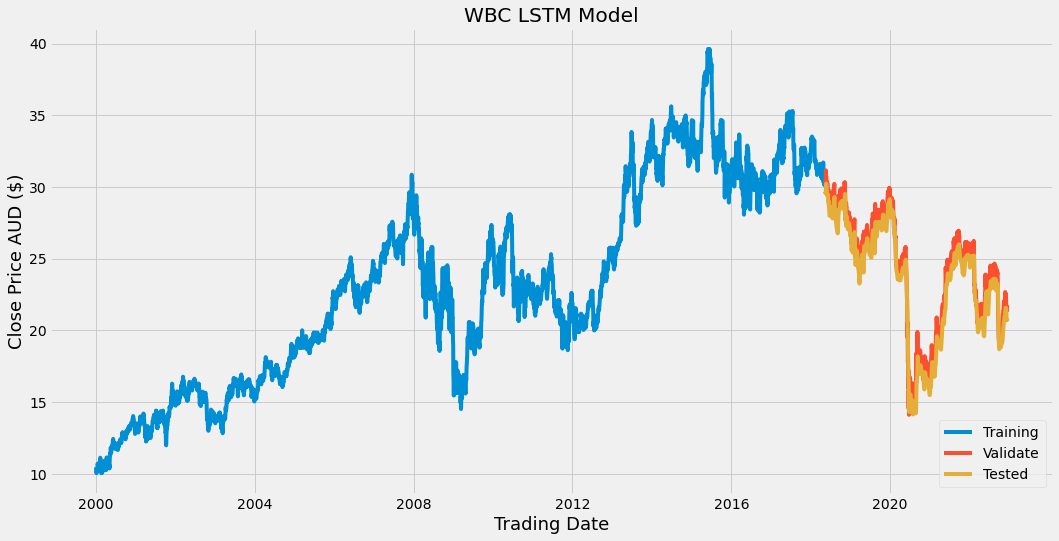

In [27]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('WBC LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/wbc_graph.png')
plt.show()

# Test data Predictions on the Model

In [28]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_41224/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4591,30.110001,29.660168,0.449833
4592,30.170000,29.600399,0.569601
4593,30.219999,29.558805,0.661194
4594,30.490000,29.550726,0.939274
4595,31.070000,29.646349,1.423651
...,...,...,...
5733,21.379999,20.980177,0.399822
5734,21.590000,20.759150,0.830851
5735,21.680000,20.693640,0.986361
5736,21.270000,20.724091,0.545910


In [29]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wbc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [30]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [31]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $21.280000686645508 Predicted next day share price $20.48


# Save the Model

In [32]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/wbc_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list wbc_sixty and load df

#PREDICT USING LOADED MODEL

In [33]:
from keras.models import load_model
model_in = load_model('../static/wbc_model.sav')

In [34]:

# query the wbc collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db.wbc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[23.41      ],
       [21.959999  ],
       [21.030001  ],
       [20.85      ],
       [19.26      ],
       [19.65      ],
       [19.280001  ],
       [18.799999  ],
       [19.129999  ],
       [19.209999  ],
       [19.440001  ],
       [19.620001  ],
       [19.290001  ],
       [19.799999  ],
       [19.620001  ],
       [19.620001  ],
       [19.5       ],
       [19.42      ],
       [19.615     ],
       [19.465     ],
       [19.6       ],
       [19.719999  ],
       [19.915001  ],
       [19.790001  ],
       [19.92      ],
       [19.955     ],
       [19.790001  ],
       [19.52      ],
       [20.049999  ],
       [20.01      ],
       [20.450001  ],
       [20.51      ],
       [20.700001  ],
       [20.9       ],
       [21.059999  ],
       [21.049999  ],
       [21.41      ],
       [21.469999  ],
       [21.23      ],
       [21.55999947],
       [21.57999992],
       [21.84499931],
       [21.86000061],
       [21.84000015],
       [21.72999954],
       [21

#Create a function to loop through the days input

In [35]:
from keras.models import load_model
model_in = load_model('../static/wbc_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_wbc(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_wbc(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[21.21,
 21.2,
 21.18,
 21.16,
 21.14,
 21.12,
 21.1,
 21.07,
 21.06,
 21.03,
 21.01,
 20.98,
 20.96,
 20.93,
 20.91,
 20.88,
 20.85,
 20.83,
 20.8,
 20.77,
 20.75,
 20.72,
 20.69,
 20.67,
 20.64,
 20.61,
 20.58,
 20.56,
 20.54,
 20.52,
 20.51,
 20.49,
 20.48,
 20.46,
 20.44,
 20.43,
 20.41,
 20.39,
 20.37,
 20.35,
 20.33,
 20.31,
 20.29,
 20.27,
 20.25,
 20.23,
 20.21,
 20.19,
 20.17,
 20.14,
 20.12,
 20.1,
 20.09,
 20.08,
 20.07,
 20.06,
 20.04,
 20.03,
 20.02,
 20.01,
 20.0,
 19.99,
 19.98,
 19.97,
 19.96,
 19.95,
 19.94,
 19.93,
 19.92,
 19.91,
 19.9,
 19.89,
 19.88,
 19.87,
 19.86,
 19.85,
 19.84,
 19.83,
 19.83,
 19.82,
 19.81,
 19.8,
 19.79,
 19.78,
 19.78,
 19.77,
 19.76,
 19.76,
 19.75,
 19.74,
 19.73,
 19.73,
 19.72,
 19.71,
 19.71,
 19.7,
 19.69,
 19.69,
 19.68,
 19.68,
 19.67,
 19.66,
 19.66,
 19.65,
 19.65,
 19.64,
 19.64,
 19.63,
 19.63,
 19.62,
 19.62,
 19.62,
 19.61,
 19.61,
 19.6,
 19.6,
 19.6,
 19.59,
 19.59,
 19.58,
 19.58,
 19.58,
 19.57,
 19.57,
 19.57,
 19.56,
 19

In [36]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [37]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')

#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')
today_str=today1.strftime('%d-%m-%Y')
print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')
    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)
    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[10:].values
    print(dates_val)

2022-08-31 00:00:00 2022-08-30 00:00:00
4:23:05.023822
[[ObjectId('630dc684ae0967d012939261') 11 '14-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939262') 12 '15-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939263') 13 '16-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939264') 14 '19-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d012939265') 15 '20-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d012939266') 16 '21-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939267') 17 '22-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939268') 18 '23-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939269') 19 '26-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d01293926a') 20 '27-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d01293926b') 21 '28-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d01293926c') 22 '29-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d01293926d') 23 '30-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d01293926e') 24 '03-10-2022' 'Monday']
 [ObjectId('630dc6

C:\Users\antoi\AppData\Local\Temp/ipykernel_41224/3344684758.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


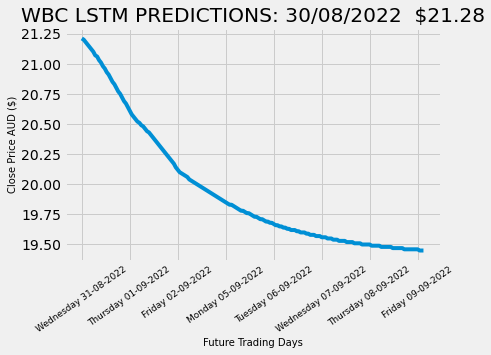

In [38]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('WBC LSTM PREDICTIONS: '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/wbc_pred.png', bbox_inches="tight")
plt.show()

In [39]:
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 21.21},
 {'Price': 21.2},
 {'Price': 21.18},
 {'Price': 21.16},
 {'Price': 21.14},
 {'Price': 21.12},
 {'Price': 21.1},
 {'Price': 21.07},
 {'Price': 21.06},
 {'Price': 21.03},
 {'Price': 21.01},
 {'Price': 20.98},
 {'Price': 20.96},
 {'Price': 20.93},
 {'Price': 20.91},
 {'Price': 20.88},
 {'Price': 20.85},
 {'Price': 20.83},
 {'Price': 20.8},
 {'Price': 20.77},
 {'Price': 20.75},
 {'Price': 20.72},
 {'Price': 20.69},
 {'Price': 20.67},
 {'Price': 20.64},
 {'Price': 20.61},
 {'Price': 20.58},
 {'Price': 20.56},
 {'Price': 20.54},
 {'Price': 20.52},
 {'Price': 20.51},
 {'Price': 20.49},
 {'Price': 20.48},
 {'Price': 20.46},
 {'Price': 20.44},
 {'Price': 20.43},
 {'Price': 20.41},
 {'Price': 20.39},
 {'Price': 20.37},
 {'Price': 20.35},
 {'Price': 20.33},
 {'Price': 20.31},
 {'Price': 20.29},
 {'Price': 20.27},
 {'Price': 20.25},
 {'Price': 20.23},
 {'Price': 20.21},
 {'Price': 20.19},
 {'Price': 20.17},
 {'Price': 20.14},
 {'Price': 20.12},
 {'Price': 20.1},
 {'Price': 20.09

In [40]:
# DRAW THE PREDICTION
# df_len = len(df.index) # length of the original dataframe
len_df_mongo = len(df_mongo.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4591 5738 5898


,Close
5887,19.46
5888,19.46
5889,19.46
5890,19.46
5891,19.46
5892,19.46
5893,19.46
5894,19.45
5895,19.45
5896,19.45


In [41]:
len_df_mongo = len(df_mongo.index) # length of the original dataframe
print(train_data_len,len(df_mongo),train_data_len-5886,4569/5886,len_df_mongo)

4591 5738 -1295 0.7762487257900101 5738


C:\Users\antoi\AppData\Local\Temp/ipykernel_41224/1661865422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


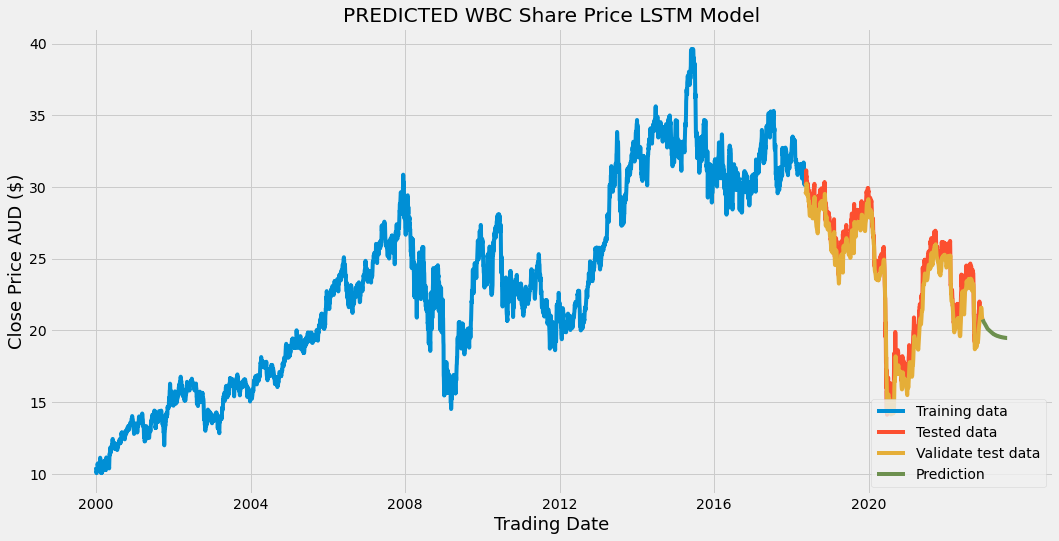

In [42]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTED WBC Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/wbc_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [43]:
# Query all
name = 'WBC'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62f86c94e8aa99df83075c2c'), 'model': 'RFR', 'name': 'WBC', 'date': '12/08/2022', 'predicted': 31, 'actual': 22, 'difference': 9.5487, 'accuracy': 97.02}
{'_id': ObjectId('630c9b5bef573254d440dc7d'), 'model': 'LSTM', 'name': 'WBC', 'date': '29/08/2022', 'predicted': 20.85, 'actual': 21.27, 'differece': -0.41999999999999815, 'rmse': 0.59742}


In [44]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f86c94e8aa99df83075c2c'), 'model': 'RFR', 'name': 'WBC', 'date': '12/08/2022', 'predicted': 31, 'actual': 22, 'difference': 9.5487, 'accuracy': 97.02}


In [45]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close

print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022, predicted $20.48, actual $21.28, difference -0.8000000000000007, rmse 0.76755


In [46]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'differece': difference,
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f86c94e8aa99df83075c2c'), 'model': 'RFR', 'name': 'WBC', 'date': '12/08/2022', 'predicted': 31, 'actual': 22, 'difference': 9.5487, 'accuracy': 97.02}
{'_id': ObjectId('630dda39741596a264e3581a'), 'model': 'LSTM', 'name': 'WBC', 'date': '30/08/2022', 'predicted': 20.48, 'actual': 21.28, 'differece': -0.8000000000000007, 'rmse': 0.76755}


In [47]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'